In [1]:
import polars as pl
import numpy as np
from pathlib import Path
import h3pandas
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
# Define the input directory and get the list of parquet files
input_dir = Path('../data/output')
output_dir = Path('../data/output-joining')

c_files = list(input_dir.glob('continuous*.parquet'))
d_files = list(input_dir.glob('discrete*.parquet'))
c_output = output_dir / 'raster_combined-continuous.parquet'
d_output = output_dir / 'raster_combined-discrete.parquet'


In [3]:
#Functions
N = 1000

@np.vectorize
def is_prime(n):
    if n == 1: return 0
    if n % 2 == 0 and n > 2:
        return 0
    return int(all(n % i for i in range(3, int(np.sqrt(n)) + 1, 2)))

@np.vectorize
def is_polygonal(s, x):
    assert s > 2 and s % 1 == 0 and x % 1 == 0
    n = (np.sqrt(8 * (s - 2) * x + (s - 4) ** 2) + (s - 4)) / (2 * (s - 2))
    return n % 1 == 0

@np.vectorize
def is_fibonacci(n):
    a, b = 0,1
    while a < n:
        a, b = b, a + b
    return a == n

@np.vectorize
def is_perfect(n):
    sum = 1
    i = 2
    while i * i <= n:
        if n % i == 0:
            sum = sum + i + n/i
        i += 1
    return sum == n and n != 1

def is_triangular(n):
    return is_polygonal(3, n)

def is_rectangular(n):
    return is_polygonal(4, n)

def is_pentagonal(n):
    return is_polygonal(5, n)

def is_hexagonal(n):
    return is_polygonal(6, n)

funcs = [
    is_prime,
    is_triangular, is_rectangular, is_pentagonal, is_hexagonal,
    is_fibonacci,
    is_perfect
]



def process_file(i, file, scale=1):
    """Processes a single file, scaling values and checking for primes."""
    # Read the parquet file
    df = pl.read_parquet(file)
       
    # Add the prime boolean to the DataFrame
    if df['value'].is_integer():
        scaled = (df['value'] * scale)
    else:
        scaled = (df['value'] * scale).floor()
    
    for func in funcs:
        f = lambda v: int(func(v))
        df = df.with_columns([
            pl.Series(f"{func.__name__}_{i}", scaled.map_elements(f, return_dtype=int))
        ])
    df = df.drop("value")
    df = df.with_columns(sum=pl.sum_horizontal(df.columns[1:]))[["h3_12","sum"]]
    df = df.rename({"sum": f"sum_{i}"})
    return df


def classify(files, N, scale=1):
    # Process files in parallel
    dfs = Parallel(n_jobs=-1)(delayed(process_file)(i, file, scale) for i, file in enumerate(tqdm(files[:N], desc="Processing files")))

    final_df = dfs[0]

    # Join all DataFrames on the "h3_12" column
    for i, df in enumerate(tqdm(dfs[1:], desc="Joining DataFrames")):
        final_df = final_df.join(df, on="h3_12", how="outer_coalesce")

    return final_df

def summing(df):
    return df.with_columns(sum=pl.sum_horizontal(df.columns[1:]))[["h3_12","sum"]]


In [4]:
%%time
# Process and classify the files
N = 10
final_df = classify(c_files, N, scale=100)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 9/9 [00:00<00:00, 1498.86it/s]

CPU times: total: 46.9 ms
Wall time: 956 ms


CPU times: total: 62.5 ms
Wall time: 671 ms


<Axes: >

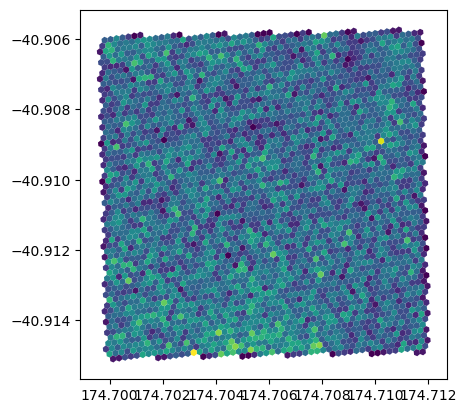

In [5]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [6]:
%%time
# Process and classify the files
N = 100
final_df = classify(c_files, N, scale=100)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 99/99 [00:00<00:00, 2250.05it/s]

CPU times: total: 266 ms
Wall time: 2.62 s


CPU times: total: 156 ms
Wall time: 376 ms


<Axes: >

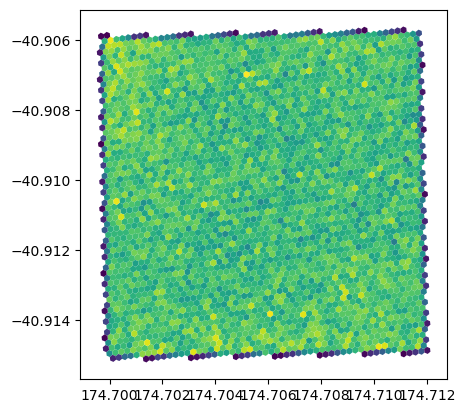

In [7]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [8]:
%%time
# Process and classify the files
N = 1000  
final_df = classify(c_files, N, scale=100)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 999/999 [00:01<00:00, 737.63it/s] 

CPU times: total: 2.78 s
Wall time: 25.2 s


CPU times: total: 109 ms
Wall time: 352 ms


<Axes: >

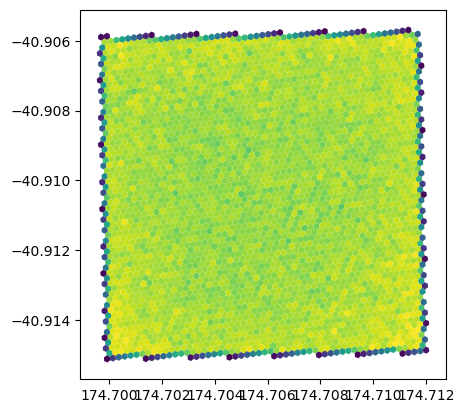

In [9]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [10]:
%%time
# Process and classify the files
N = 10000  
final_df = classify(c_files, N, scale=100)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 9999/9999 [02:22<00:00, 70.41it/s] 

CPU times: total: 10min 38s
Wall time: 6min 20s


CPU times: total: 93.8 ms
Wall time: 373 ms


<Axes: >

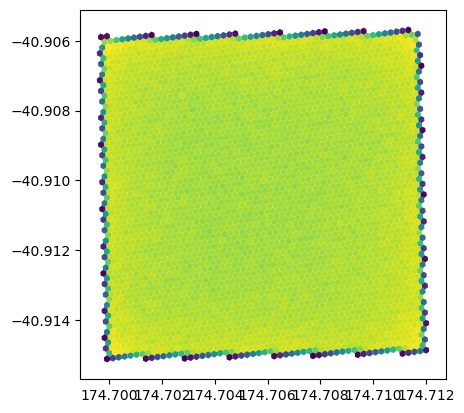

In [11]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [12]:
pdf.to_parquet(c_output)

In [13]:
%%time
# Process and classify the files
N = 10
final_df = classify(d_files, N, scale=1)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 9/9 [00:00<00:00, 593.33it/s]

CPU times: total: 15.6 ms
Wall time: 342 ms


CPU times: total: 62.5 ms
Wall time: 426 ms


<Axes: >

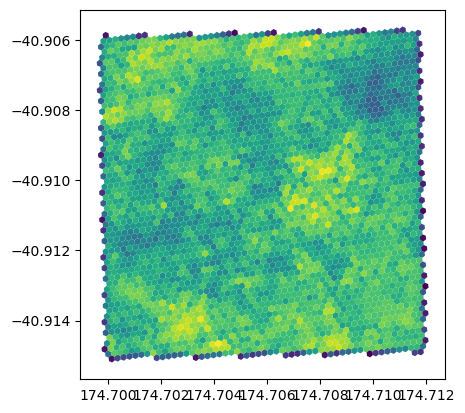

In [14]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [15]:
%%time
# Process and classify the files
N = 100
final_df = classify(d_files, N, scale=1)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 99/99 [00:00<00:00, 1677.99it/s]

CPU times: total: 359 ms
Wall time: 2.8 s


CPU times: total: 15.6 ms
Wall time: 384 ms


<Axes: >

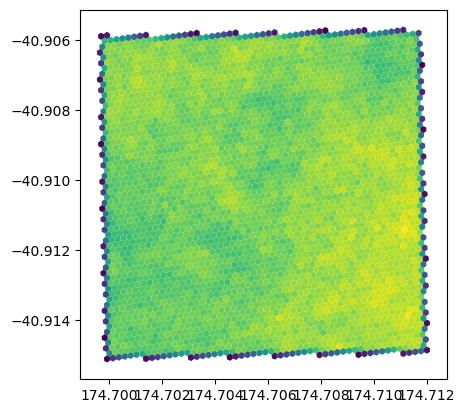

In [16]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [17]:
%%time
# Process and classify the files
N = 1000
final_df = classify(d_files, N, scale=1)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 999/999 [00:02<00:00, 484.67it/s] 

CPU times: total: 3.7 s
Wall time: 27 s


CPU times: total: 62.5 ms
Wall time: 505 ms


<Axes: >

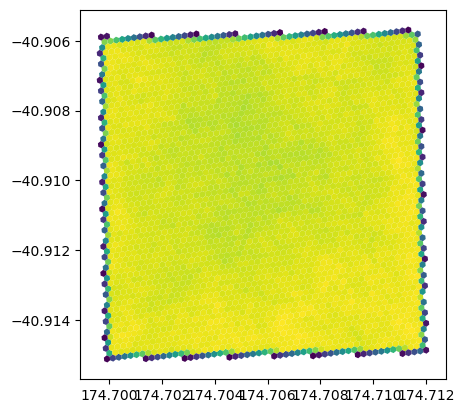

In [18]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [19]:
%%time
# Process and classify the files
N = 10000
final_df = classify(d_files, N, scale=1)
final_df = summing(final_df)

Joining DataFrames: 100%|██████████| 9999/9999 [02:25<00:00, 68.67it/s] 


CPU times: total: 10min 18s
Wall time: 6min 32s


CPU times: total: 93.8 ms
Wall time: 399 ms


<Axes: >

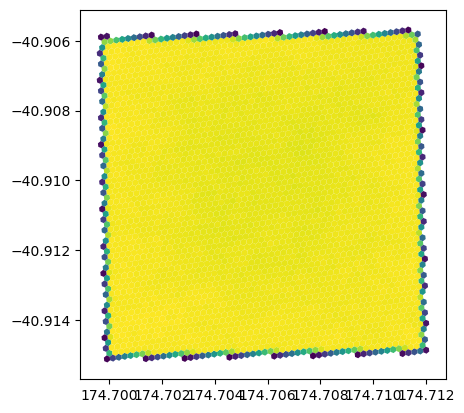

In [20]:
%%time 
#drawing the h3 geometries is neglegible
pdf=final_df.to_pandas()
pdf=pdf.set_index("h3_12").h3.h3_to_geo_boundary()
pdf.plot('sum')

In [21]:
pdf.to_parquet(d_output)